# Модель для предсказания урожайности с/х культур для территории Франции

In [273]:
# Загрузка всех необходимых библиотек
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats
from datetime import datetime
from pyproj import Proj, transform
from sklearn.feature_extraction import DictVectorizer as DV
from sklearn.metrics import mean_absolute_error, mean_squared_error, median_absolute_error, r2_score
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.linear_model import Lasso, Ridge, PassiveAggressiveRegressor, SGDRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.linear_model import RANSACRegressor
import pickle

from datetime import date
import warnings
warnings.filterwarnings("ignore")

from matplotlib import pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap
from matplotlib import pyplot
from mpl_toolkits.mplot3d import Axes3D
from pylab import rcParams
rcParams['figure.figsize'] = 15, 8

## Загружаем исходный датасет в память компьютера

In [274]:
data = pd.read_csv('/media/mikhail/Data/ITMO/Reanalysis_grid_Europe/Processed_grid/France.csv', sep = ',')
data.head(10)

,Precip_amount,Precip_days,Pressure_mean,Sweden_pressure,Ireland_pressure,Portugal_pressure,Greece_pressure,Temperature_max,Temperature_min,Temperature_SAT,...,Barley (tonnes per hectare),Cocoa beans (tonnes per hectare),Bananas (tonnes per hectare),Nitrogen fertilizer use (kilograms per hectare),Tractors per 100 sq km arable land,Total population (Gapminder),Entity,Land used for cereal (hectares),Cereal production (tonnes),Cereal yield (tonnes per hectare)
0,335.01044,57.0,1007.24774,1002.46170,995.21630,1013.98834,949.85310,29.134650,-5.330618,1254.76780,...,2.3960,NaN,NaN,NaN,379.169642,46267000.0,France,9140300.0,20802475.0,2.2759
1,360.32275,60.0,1006.49133,1003.04160,997.25440,1012.53150,947.95013,28.045279,-8.618263,889.18450,...,2.7581,NaN,NaN,NaN,411.898618,46907000.0,France,9408120.0,25305105.0,2.6897
2,400.16974,68.0,1003.21857,1009.54596,993.74610,1009.40594,946.64340,27.724977,-15.544219,991.49500,...,2.9088,NaN,NaN,NaN,445.991262,47561000.0,France,9159745.0,25367307.0,2.7694
3,341.88293,56.0,1006.48865,1008.34420,996.31190,1011.71810,950.08570,29.009813,-8.429693,1172.55940,...,2.8774,NaN,NaN,NaN,499.380438,48184000.0,France,9226542.0,26050470.0,2.8234
4,361.47696,66.0,1013.66675,1004.89140,996.11790,1012.11725,947.29913,28.526762,-8.956021,1030.35800,...,3.0363,NaN,NaN,NaN,530.124495,48747000.0,France,9377274.0,29130754.0,3.1065
5,426.55893,71.0,1010.90375,1007.26660,990.89276,1011.42180,947.27020,27.397085,-13.636804,1217.53630,...,2.8093,NaN,NaN,NaN,569.340302,49233000.0,France,9194306.0,26737646.0,2.9081
6,311.75888,56.0,1006.91370,1002.95180,995.52360,1013.38960,949.63763,28.040749,-11.131484,983.20130,...,3.5037,NaN,NaN,NaN,612.255477,49651000.0,France,9303635.0,32345675.0,3.4767
7,400.44086,67.0,1001.73690,1002.37256,995.36950,1011.64386,948.65576,27.963236,-10.241153,992.05164,...,3.2861,NaN,NaN,NaN,670.491496,50025000.0,France,9307842.0,33237542.0,3.5709
8,443.24603,72.0,1006.93054,1009.15950,992.91064,1009.18420,947.13306,27.126726,-10.414920,1022.12390,...,3.3067,NaN,NaN,NaN,688.307999,50387000.0,France,9375548.0,33115628.0,3.5321
9,469.44174,82.0,1010.25480,1005.29070,993.67240,1011.54816,947.11945,27.391870,-9.210229,1023.67993,...,2.7772,NaN,NaN,NaN,706.321410,50764000.0,France,9318100.0,31443420.0,3.3744


## Визуализация данных

Отоюразим некоторые данные на графиках. Сначала посмотрим на давление по странам:

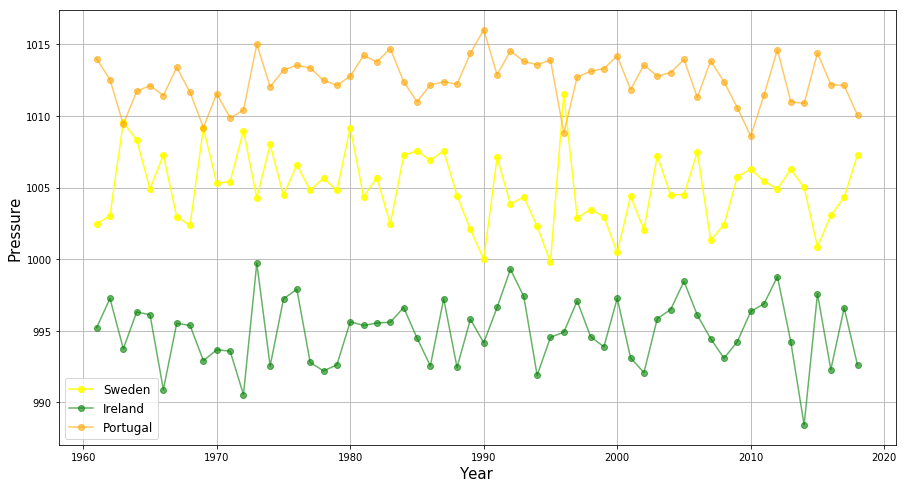

In [275]:
plt.plot(data['Year'], data['Sweden_pressure'], '-ok', c = 'yellow', alpha = 0.9, label = 'Sweden')
plt.plot(data['Year'], data['Ireland_pressure'], '-ok', c = 'green', alpha = 0.6, label = 'Ireland')
plt.plot(data['Year'], data['Portugal_pressure'], '-ok', c = 'orange', alpha = 0.6, label = 'Portugal')
#plt.plot(data['Year'], data['Greece_pressure'], '-ok', c = 'blue', alpha = 0.6, label = 'Greece')
plt.xlabel('Year', fontsize = 15)
plt.ylabel('Pressure', fontsize = 15)
plt.legend(fontsize = 12)
plt.grid()
plt.show()

Нарисуем временные ряды по годам

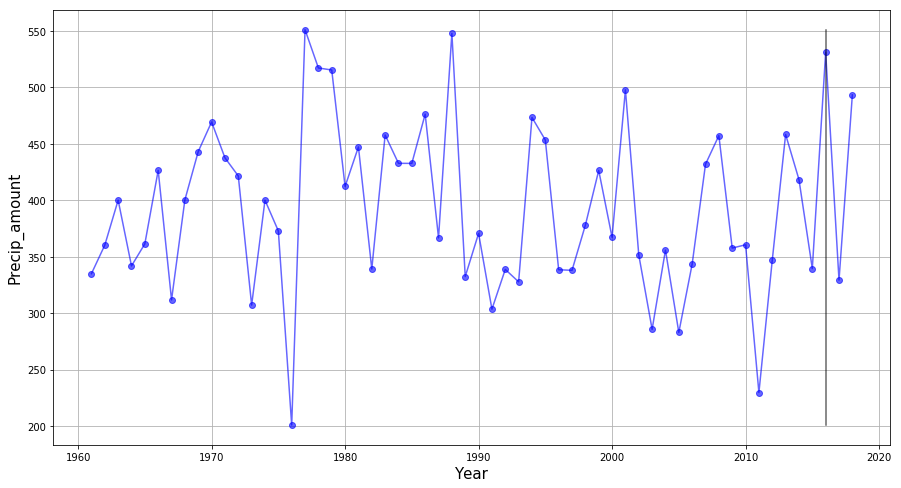

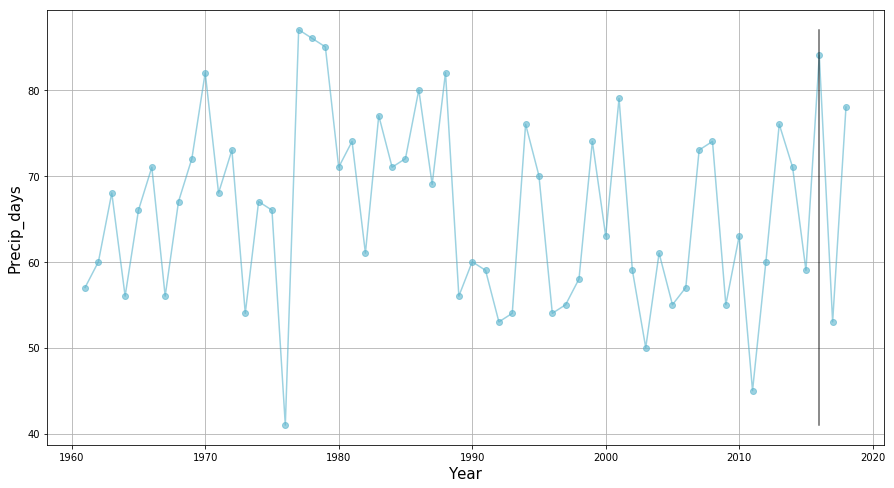

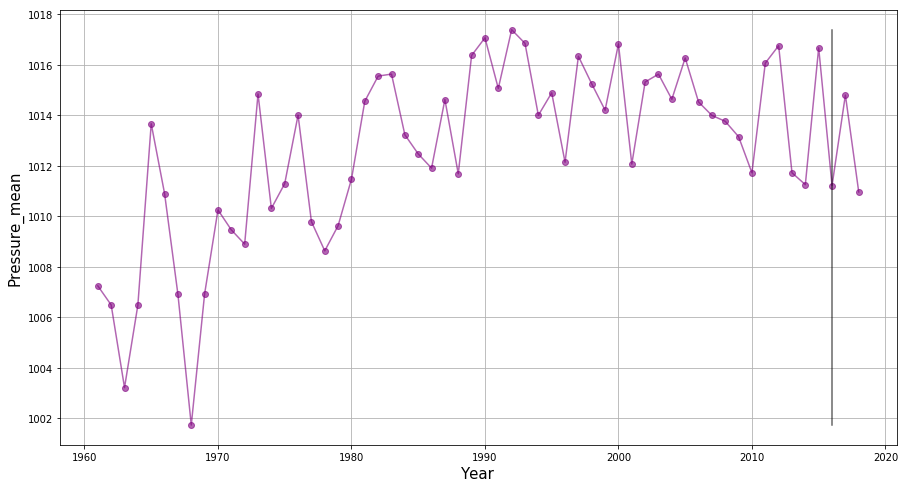

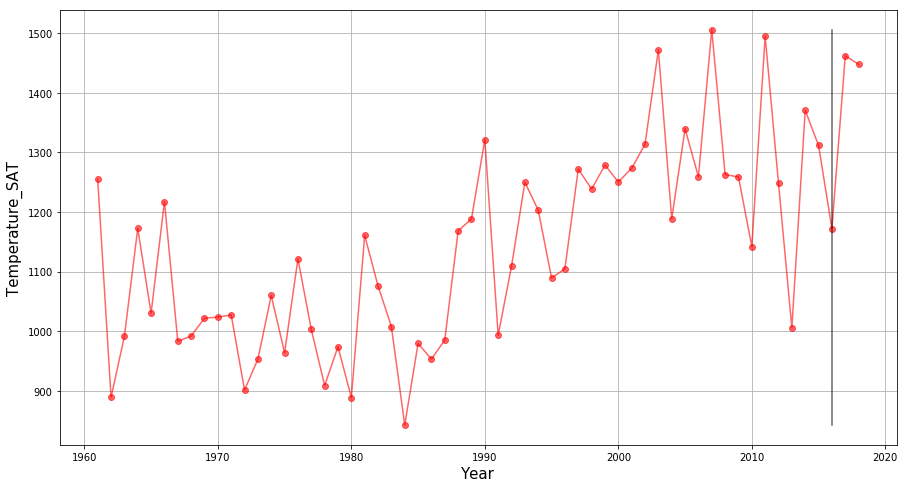

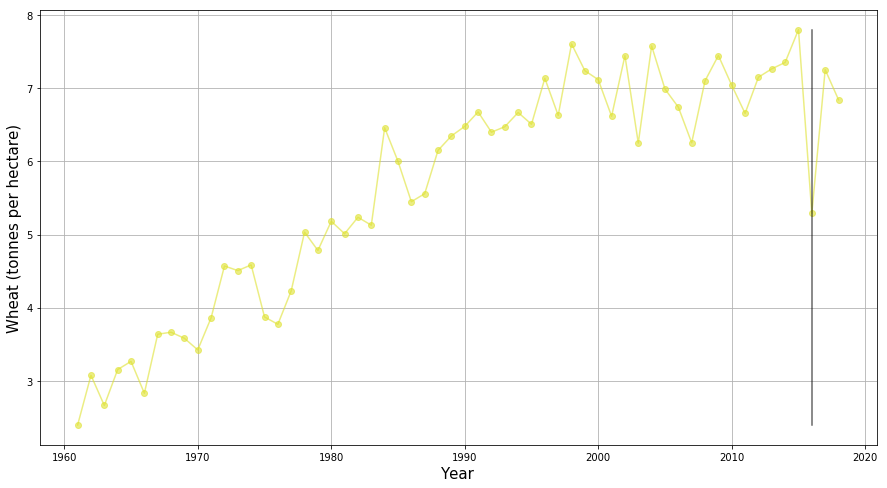

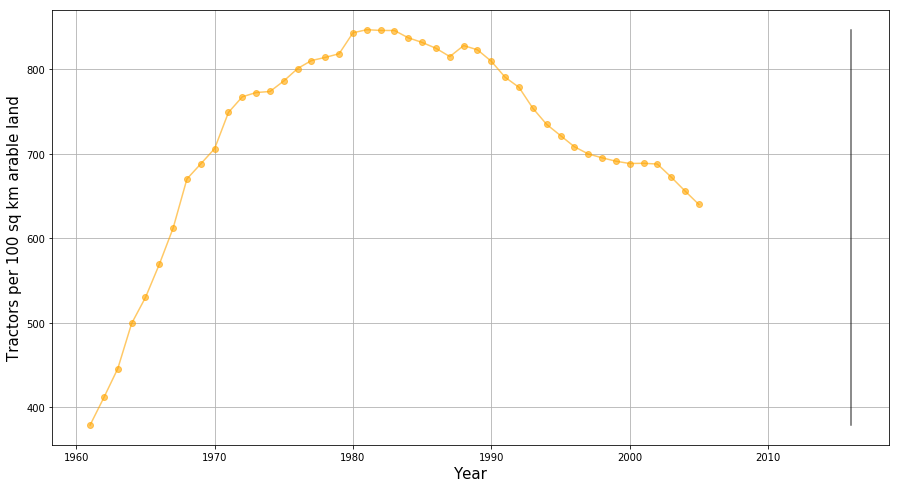

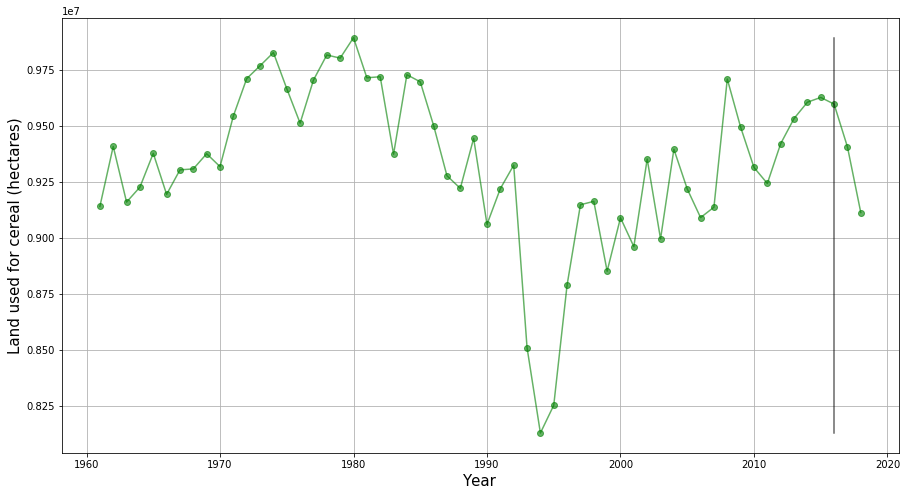

In [276]:
def simple_plot(data, color):
    plt.plot(data['Year'], data[column], '-ok', c = color, alpha = 0.6)
    # Отобразим на графиках линию - в 2016 году был замечен серьезный спад в урожайности
    plt.plot([2016,2016], [min(data[column]), max(data[column])], c = 'black', alpha = 0.6)
    plt.xlabel('Year', fontsize = 15)
    plt.ylabel(column, fontsize = 15)
    plt.grid()
    plt.show()

for column in data.columns:
    # Выбираем цвет в зависимости от отображаемого параметра
    if column == 'Precip_amount':
        simple_plot(data, color = 'blue')
    elif column == 'Precip_days':
        simple_plot(data, color = '#5BB4CD') 
    elif column == 'Pressure_mean':
        simple_plot(data, color = 'purple') 
    elif column == 'Temperature_SAT':
        simple_plot(data, color = 'red')
    elif column == 'Temperature_SAT':
        simple_plot(data, color = 'red')
    elif column == 'Tractors per 100 sq km arable land':
        simple_plot(data, color = 'orange')
    elif column == 'Land used for cereal (hectares)':
        simple_plot(data, color = 'green')
    elif column == 'Wheat (tonnes per hectare)':
        simple_plot(data, color = '#DFE231')
    else:
        pass
    

Как видно из графика Wheat (tonnes per hectare), временной ряд, составленный из значений урожайности пшеницы имеет явный тренд. Отсюда мы предполагаем то, что нам следует анализировать не весь ряд целиком, а только однородные части.

## Взаимосвязи между переменными

In [277]:
Newtable = data[['Precip_amount', 'Precip_days', 'Pressure_mean', 'Sweden_pressure',
                'Ireland_pressure', 'Portugal_pressure', 'Temperature_max', 'Temperature_min',
                'Temperature_SAT','Land used for cereal (hectares)', 'Wheat (tonnes per hectare)']]
Newtable = Newtable.dropna()
corr = Newtable.corr()
corr.style.background_gradient(cmap = 'coolwarm')

,Precip_amount,Precip_days,Pressure_mean,Sweden_pressure,Ireland_pressure,Portugal_pressure,Temperature_max,Temperature_min,Temperature_SAT,Land used for cereal (hectares),Wheat (tonnes per hectare)
Precip_amount,1,0.962949,-0.335574,-0.0314874,-0.678262,-0.205448,-0.486719,0.0502623,-0.266761,0.104639,-0.0808019
Precip_days,0.962949,1,-0.346626,0.0146561,-0.653469,-0.188939,-0.501383,-0.00786756,-0.340913,0.180216,-0.144295
Pressure_mean,-0.335574,-0.346626,1,-0.333843,0.399896,0.54303,0.423508,0.167745,0.455616,-0.190946,0.694858
Sweden_pressure,-0.0314874,0.0146561,-0.333843,1,-0.127582,-0.683842,-0.162772,-0.390076,-0.325228,0.240569,-0.227932
Ireland_pressure,-0.678262,-0.653469,0.399896,-0.127582,1,0.413194,0.255257,-0.119301,-0.00176769,-0.0312385,0.080128
Portugal_pressure,-0.205448,-0.188939,0.54303,-0.683842,0.413194,1,0.151038,0.3158,0.138267,-0.0650796,0.124304
Temperature_max,-0.486719,-0.501383,0.423508,-0.162772,0.255257,0.151038,1,0.108397,0.646288,-0.300227,0.434373
Temperature_min,0.0502623,-0.00786756,0.167745,-0.390076,-0.119301,0.3158,0.108397,1,0.22994,0.0682914,0.178286
Temperature_SAT,-0.266761,-0.340913,0.455616,-0.325228,-0.00176769,0.138267,0.646288,0.22994,1,-0.395553,0.523444
Land used for cereal (hectares),0.104639,0.180216,-0.190946,0.240569,-0.0312385,-0.0650796,-0.300227,0.0682914,-0.395553,1,-0.228607


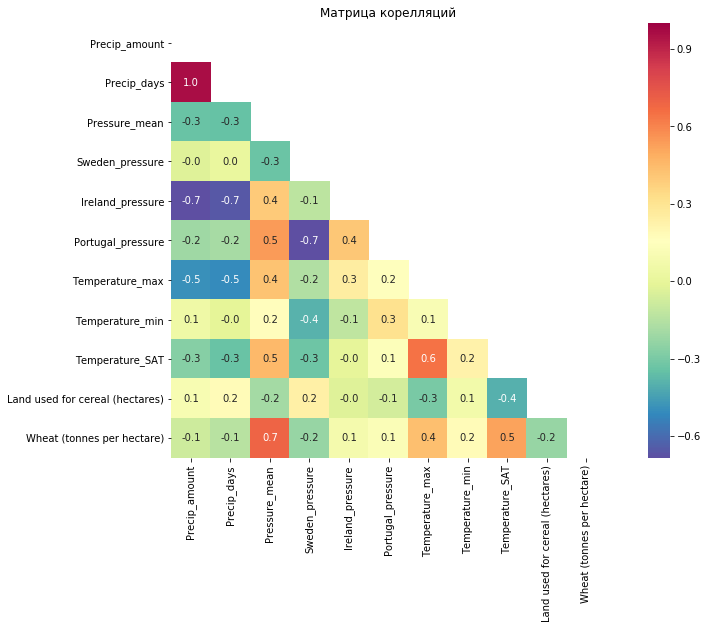

In [279]:
corrs = Newtable.corr()
mask = np.zeros_like(corrs)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corrs, cmap='Spectral_r', annot=True, fmt= '.1f', mask = mask, square = True)
plt.title('Матрица корелляций')
plt.show()

Таким образом, наиболее сильная линейная взимосвязь с откликом (Wheat (tonnes per hectare)) установлена для:

- Среднее давление для данной страны за первое полугодие (R = 0.69)
- Сумма активных температур выше 10 градусов за первое полугодие (R = 0.52)
- Максимальная температура воздуха за первое полугодие (R = 0.43)
- Среднее давление на территории Швеции за первое полугодие (R = -0.23)
- Площадь используемых в с/х земель (R = -0.22)
- Минимальная температура воздуха за первое полугодие (R = 0.18)

## Метод кумулятивных сумм и статистическое тестирование с целью разделения выборки на однородные части

Метод интегральных кривых или накопленных (кумулятивных) сумм первоначально применялся в гидрологии для проверки наличия или отсутствия направленных изменений (тренда) в межгодовой динамике годовых расходов рек (Стандарт ГГИ, 2017). Впоследствии он стал применяться для предварительного анализа межгодовой изменчивости любых параметров окружающей среды. 

Сущность метода заключается в следующем. Строится график: по оси абсцисс откладываются обозначения лет, по оси ординат – накопленные суммы среднегодовых или суммарных за год значений параметра. Накопленная сумма для данного года – это сумма значений ряда от самого его начала до данного года. Для первого года ряда это само значение, для второго года – сумма значений первого и второго года и т.д. Точки накопленных сумм на графике соединяются линией. Если нет выраженного межгодового тренда в изменении значений ряда, то линия по форме близка к прямой. Если на линии присутствуют изломы, то это может свидетельствовать о неоднородности ряда значений.

Зададим функцию для построения графика и выделения точки излома.

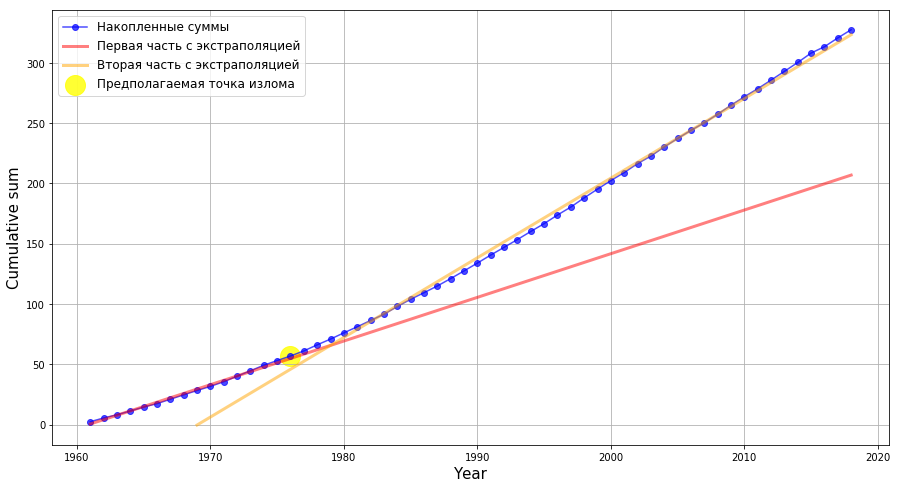

Предполагаемый год излома - 1976
Индекс предполагаемого излома - 15


In [272]:
def cum_sum(array, years):  
    # Рассчет накопленных сумм
    cumsum_array = np.cumsum(array)
    
    # Рассчитываем среднюю разницу между соседними элементами массива
    diffs = []
    for i in range(0, len(cumsum_array)):
        if i == 0:
            pass
        else:
            last = cumsum_array[i-1]
            current = cumsum_array[i]
            diff = current - last
            diffs.append(diff)
    diffs = np.array(diffs)
    
    # Медианное значение разницы между соседними элементами
    median_diff = np.median(diffs)
    
    # Поиск наиболее заметного перелома:
    fractures = []
    for i in range(0, len(cumsum_array)):
        if i == 0:
            fractures.append(0)
        elif i == 1:
            fractures.append(0)
        else:
            pre_last = cumsum_array[i-2]
            last = cumsum_array[i-1]
            current = cumsum_array[i]
            # Действующая разница 
            curr_diff = current - last
            last_diff = last - pre_last
            main_diff = (curr_diff + last_diff)/2
            
            # Насколько действующая разница больше или меньше среднего значения разности
            value = abs(main_diff - median_diff)
            fractures.append(value)
    fractures = np.array(fractures)
    
    # Условимся считать, что первые 15 и последние 15 элементов в ряду 
    # нам не слудет рассматривать при поиске излома
    new_fractures = fractures[15:-15]
        
    # Допустимый уровень расхожения - 10 процентов
    threshold = ((max(array) - min(array))/100)*10
    # Если хотя бы одно значение из массива больше порогового, то мы имеем дело с изломом
    if any(threshold < fracture for fracture in new_fractures):
        # Индекс "переломного момента"
        id_fracture = np.argwhere(fractures == max(new_fractures))[0][0]
        year_fracture = int(years[id_fracture])
        
        # Линейная регрессия для первой части ряда
        LR1 = LinearRegression()
        years_1 = np.array(years[:id_fracture]).reshape((-1,1))
        cumsum_1 =  np.array(cumsum_array[:id_fracture]).reshape((-1,1))
        LR1.fit(years_1, cumsum_1)
        
        # Линейная регрессия для второй части ряда
        LR2 = LinearRegression()
        years_2 = np.array(years[id_fracture:]).reshape((-1,1))
        cumsum_2 =  np.array(cumsum_array[id_fracture:]).reshape((-1,1))
        LR2.fit(years_2, cumsum_2)
        
        
        # Зададим две точки, по которым будем рисовать прямую
        l1 = np.array([[min(years)], [max(years)]])
        l2 = np.array([[1969], [max(years)]])

        plt.plot(years, cumsum_array, '-ok', c = 'blue', alpha = 0.7, label = 'Накопленные суммы')
        plt.plot(l1, LR1.predict(l1), c = 'red', alpha = 0.5, label = 'Первая часть с экстраполяцией', linewidth = 3)
        plt.plot(l2, LR2.predict(l2), c = 'orange', alpha = 0.5, label = 'Вторая часть с экстраполяцией', linewidth = 3)
        plt.scatter(years[id_fracture], cumsum_array[id_fracture], c = 'yellow', s = 400, alpha = 0.8, label = 'Предполагаемая точка излома')
        plt.xlabel('Year', fontsize = 15)
        plt.ylabel('Cumulative sum', fontsize = 15)
        plt.legend(fontsize = 12)
        plt.grid()
        plt.show()

        print('Предполагаемый год излома -', year_fracture)
        print('Индекс предполагаемого излома -', id_fracture)
    else:
        print('Изломов не обнаружено')
    
cum_sum(data['Wheat (tonnes per hectare)'], data['Year'])

Итак, на графике видно точку излома.

То есть, теперь мы можем разделить выборку на 2 части, первую до 1976 года, вторую - после 1976. Затем проверить выборки на принадлежность одной генеральной совокупности. Так и поступим.

In [234]:
arr = data['Wheat (tonnes per hectare)']
# Разделяем выборки по индексу излома
ar1 = arr[:15]
ar2 = arr[15:]

scipy.stats.ks_2samp(ar1, ar2)

Ks_2sampResult(statistic=0.9534883720930233, pvalue=9.142464563183239e-12)

Но стоит заметить, что использование критерия Колмогорова-Смирнова в данном случае неопрадвано в виду маленького числа объектов в выборках. Поэтому, стоит обратить внимание на непараметрические критерии, которые не накладывают ограничений как на нормальность распредления выборок, так и на их размер.

Воспользуемся критерием Краскела — Уоллиса, предназначенного для проверки равенства медиан нескольких выборок. Данный критерий является многомерным обобщением критерия Уилкоксона — Манна — Уитни.

In [235]:
scipy.stats.kruskal(ar1, ar2)

KruskalResult(statistic=31.189672841939313, pvalue=2.3400766441504337e-08)

Итак, выборки значимо отличаются. Поэтому с этого момента мы будем использовать только данные позднее 1976 года.

## Прогностическая модель 

Зададим необходимые функции для вывода информации о качестве модели.

In [236]:
# Зададим необходимые функции
# Расчет метрики - cредняя абсолютная процентная ошибка
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true = np.ravel(y_true)
    y_pred = np.ravel(y_pred)
    # У представленной ниже формулы есть недостаток, - если в массиве y_true есть хотя бы одно значение 0.0,
    # то по формуле np.mean(np.abs((y_true - y_pred) / y_true)) * 100 мы получаем inf, поэтому
    zero_indexes = np.argwhere(y_true == 0.0)
    for index in zero_indexes:
        y_true[index] = 0.01
    value = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return(value)

# Зададим функцию, которая будет выводить на экран значения метрик
def print_metrics(y_test, prediction, model, r2 = False):
    print('Средняя абсолютная ошибка на тестовой выборке -', mean_absolute_error(y_test, prediction))
    print('Средняя медианная ошибка на тестовой выборке -', median_absolute_error(y_test, prediction))
    print('Корень из среднеквадратической ошибки на тестовой выборке -', mean_squared_error(y_test, prediction)**0.5)
    print('Средняя абсолютная процентная ошибка на тестовой выборке -',mean_absolute_percentage_error(y_test, prediction))
    if r2 == True:
        print('Коэффициент детерминации на обучающей выборке -', r2_score(y_train, model.predict(X_train)))

# Зададим функцию для отрисовки графиков
def residuals_plots(y_test, prediction, color = 'blue'):
    prediction = np.ravel(prediction)
    y_test = np.ravel(y_test)
    # Рассчитываем ошибки
    errors = prediction - y_test
    errors = np.ravel(errors)
    with sns.axes_style("darkgrid"):
        sns.kdeplot(errors, shade = True, color = color,  kernel = 'gau', alpha = 0.6)
        plt.title('Распределение ошибок модели')
        plt.ylabel('Плотность вероятности', fontsize = 17)
        plt.xlabel('Ошибки', fontsize = 17)
        plt.show()

    plt.scatter(prediction, errors, c = color, alpha = 0.6, s = 6)
    plt.title('График остатков модели')
    plt.xlabel('Предсказанное значение продолжительности отключения, мин', fontsize = 15)
    plt.ylabel('Исходные остатки', fontsize = 15)
    plt.grid()
    plt.show()

Разделим выборку на обучение и тест. Сделаем это в явном виде. Укажем предикторы и отклик.

In [237]:
data_train = data[15:-5]
data_test = data[-5:]

# Предикторы
scaler = StandardScaler()
X_train = scaler.fit_transform(data_train[['Precip_amount' , 'Temperature_SAT', 'Precip_days', 'Pressure_mean', 'Temperature_min',
                                          'Sweden_pressure', 'Ireland_pressure', 'Portugal_pressure', 'Land used for cereal (hectares)']])
X_test = scaler.transform(data_test[['Precip_amount' , 'Temperature_SAT', 'Precip_days', 'Pressure_mean', 'Temperature_min',
                                          'Sweden_pressure', 'Ireland_pressure', 'Portugal_pressure', 'Land used for cereal (hectares)']])
                          
y_train = data_train['Wheat (tonnes per hectare)']
y_test = data_test['Wheat (tonnes per hectare)']
                          
y_train = np.ravel(y_train)
y_test = np.ravel(y_test)

Обучим первый алгоритм - линейную регрессию.

In [238]:
LR = LinearRegression()
LR.fit(X_train, y_train)
predicted = LR.predict(X_test)

Выведем результаты на экран. Посмотрим на метрики и изучим графики остатков.

Средняя абсолютная ошибка на тестовой выборке - 0.6516907859433079
Средняя медианная ошибка на тестовой выборке - 0.6018920553903149
Корень из среднеквадратической ошибки на тестовой выборке - 0.7531711567932633
Средняя абсолютная процентная ошибка на тестовой выборке - 9.75494683012272
Коэффициент детерминации на обучающей выборке - 0.5872387571153439


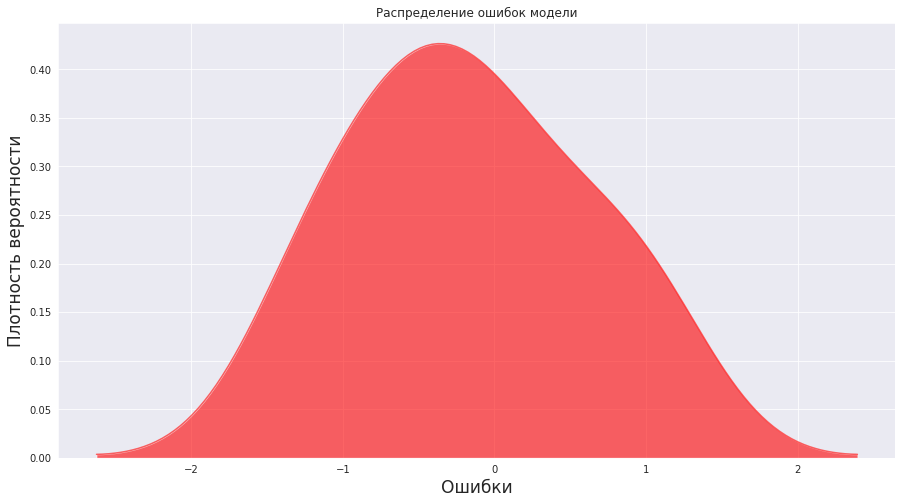

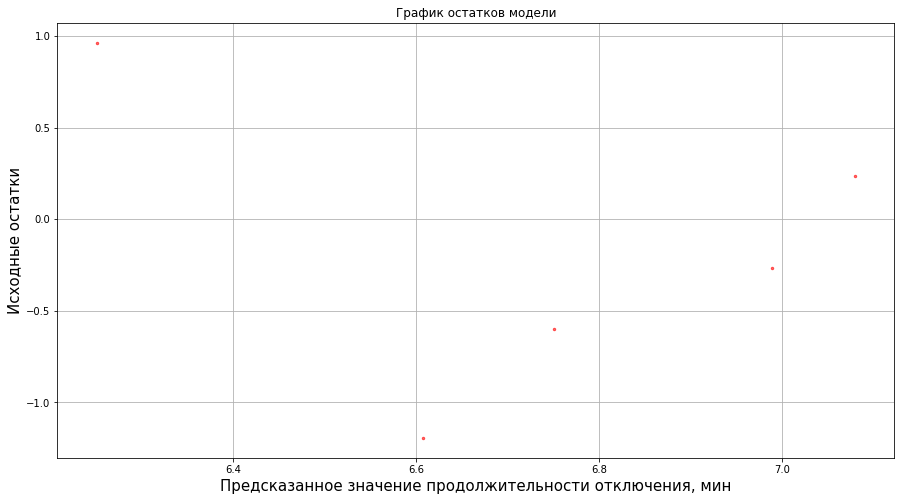

In [229]:
rcParams['figure.figsize'] = 15, 8
print_metrics(y_test, predicted, LR, r2 = True)
residuals_plots(y_test, predicted, color = 'red')